In [6]:
from madmom.processors import SequentialProcessor
from madmom.audio.chroma import DeepChromaProcessor
from madmom.features.chords import DeepChromaChordRecognitionProcessor

dcp = DeepChromaProcessor()
decode = DeepChromaChordRecognitionProcessor()
chordrec = SequentialProcessor([dcp, decode])

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
df = pd.read_csv("chord_transitions.csv")

In [20]:
transitions = []

base_dir = "temp_wavs"
label_map = {"0": "PN", "1": "NP", "2": "PP", "3": "NN"}

for label in ["0", "1", "2", "3"]:
    folder = os.path.join(base_dir, label)
    for fname in tqdm(os.listdir(folder), desc=f"Processing {label_map[label]}"):
        if not fname.endswith(".wav"):
            continue

        path = os.path.join(folder, fname)
        
        try:
            chords = chordrec(path)
            for i in range(len(chords) - 1):
                from_chord = chords[i][2]
                to_chord = chords[i + 1][2]
                transitions.append((from_chord, to_chord, label_map[label], fname))
        except Exception as e:
            print(f"{fname} 처리 실패: {e}")
            continue

df = pd.DataFrame(transitions, columns=["from", "to", "group", "filename"])
df.to_csv("chord_transitions.csv", index=False)

Processing NN: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


In [ ]:
df = pd.read_csv("chord_transitions.csv")
transition_matrix = pd.crosstab(df["from"], df["to"])

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Chord Transition Heatmap")
plt.xlabel("To Chord")
plt.ylabel("From Chord")
plt.tight_layout()
plt.show()

In [5]:
groups = df["group"].unique()

for g in groups:
    df_g = df[df["group"] == g]
    matrix = pd.crosstab(df_g["from"], df_g["to"])
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap="YlGnBu")
    plt.title(f"Chord Transition Heatmap ({g})")
    plt.xlabel("To Chord")
    plt.ylabel("From Chord")
    plt.tight_layout()
    plt.savefig(f"heatmap_{g}.png")
    plt.close()

In [ ]:
stats = []

for group in ["PP", "PN", "NP", "NN"]:
    df_g = df[df["group"] == group]
    total = len(df_g)
    unique = df_g.groupby(["from", "to"]).ngroups # -> 각 곡당 평균
    avg_freq = total / unique if unique > 0 else 0
    diversity = unique / total if total > 0 else 0
    stats.append({
        "group": group,
        "total_transitions": total,
        "unique_transitions": unique,
        "avg_freq_per_pair": round(avg_freq, 2),
        "diversity_ratio": round(diversity, 4)
    })

stats_df = pd.DataFrame(stats)
print(stats_df)

  group  total_transitions  unique_transitions  avg_freq_per_pair  \
0    PP               9190                 360              25.53   
1    PN               9349                 344              27.18   
2    NP               8610                 386              22.31   
3    NN               8236                 408              20.19   

   diversity_ratio  
0           0.0392  
1           0.0368  
2           0.0448  
3           0.0495  


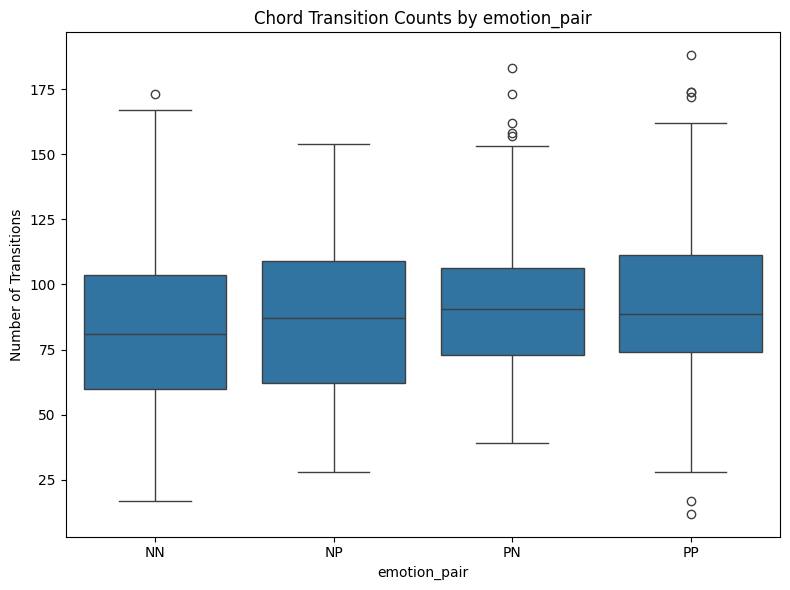

In [64]:
df_counts = df.groupby(["filename", "group"]).size().reset_index(name="transition_count")

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_counts, x="group", y="transition_count")
plt.title("Chord Transition Counts by emotion_pair")
plt.xlabel("emotion_pair")
plt.ylabel("Number of Transitions")
plt.tight_layout()
plt.show()

In [35]:
from IPython.display import display

In [24]:
for group in ["PP", "PN", "NP", "NN"]:
    print(f"\n Top 10 Chord Transitions for Emotion Pair {group}")
    df_g = df[df["group"]==group]
    top_transitions = df_g.groupby(["from", "to"]).size().sort_values(ascending=False).head(10)
    display(top_transitions.reset_index(name="count"))


 Top 10 Chord Transitions for Emotion Pair PP


,from,to,count
0,C:maj,G:maj,234
1,G:maj,D:maj,202
2,F:maj,C:maj,181
3,D:maj,G:maj,163
4,A#:maj,D#:maj,157
5,D#:maj,G#:maj,156
6,C#:maj,F#:maj,148
7,D#:maj,A#:maj,147
8,A:min,G:maj,143
9,A:maj,D:maj,143



 Top 10 Chord Transitions for Emotion Pair PN


,from,to,count
0,F:maj,C:maj,215
1,C#:maj,G#:maj,199
2,G:maj,D:maj,189
3,C:maj,F:maj,189
4,C:maj,G:maj,178
5,G#:maj,D#:maj,175
6,D:maj,A:maj,166
7,E:maj,A:maj,146
8,D:maj,G:maj,142
9,G#:maj,C#:maj,137



 Top 10 Chord Transitions for Emotion Pair NP


,from,to,count
0,D#:maj,A#:maj,166
1,A#:maj,F:maj,164
2,C:maj,E:min,132
3,F:maj,A#:maj,129
4,F:maj,G:min,125
5,C#:maj,G#:maj,109
6,C:maj,F:maj,101
7,A#:maj,D#:maj,98
8,G:maj,D:maj,97
9,D:maj,G:maj,92



 Top 10 Chord Transitions for Emotion Pair NN


,from,to,count
0,D#:maj,N,138
1,N,D#:maj,131
2,D#:maj,G#:maj,101
3,A:maj,D:maj,97
4,C#:maj,D#:maj,96
5,G#:maj,D#:maj,94
6,F:maj,C:maj,94
7,D#:maj,F:min,91
8,F:min,C#:maj,84
9,A:maj,F#:min,79


In [15]:
match_df = df[df["group"].isin(["PP", "NN"])]
mismatch_df = df[df["group"].isin(["PN", "NP"])]

match_matrix = pd.crosstab(match_df["from"], match_df["to"])
mismatch_matrix = pd.crosstab(mismatch_df["from"], mismatch_df["to"])

In [ ]:
# Q1 = transition_counts["transition_count"].quantile(0.25)
# Q3 = transition_counts["transition_count"].quantile(0.75)
# IQR = Q3 - Q1
# upper_bound = Q3 + 1.5 * IQR

# filtered = transition_counts[transition_counts["transition_count"] <= upper_bound]

In [67]:
match_total_transition_counts = (
    match_df.groupby(["filename", "group"])
    .size()
    .reset_index(name="num_total_transitions")
)

mismatch_total_transition_counts = (
    mismatch_df.groupby(["filename", "group"])
    .size()
    .reset_index(name="num_total_transitions")
)

top_match = (
    match_total_transition_counts.sort_values("num_total_transitions", ascending=False)
    # .groupby("group")
    .head(10)
)

top_mismatch = (
    mismatch_total_transition_counts.sort_values("num_total_transitions", ascending=False)
    # .groupby("group")
    .head(10)
)

display(top_match)
display(top_mismatch)

,filename,group,num_total_transitions
126,Lynyrd Skynyrd - Sweet Home Alabama.wav,PP,188
169,Sean Paul - Rockabye (feat. Sean Paul & Anne-Marie).wav,PP,174
186,Train - Play That Song.wav,PP,174
188,Travis Scott - Goosebumps.wav,NN,173
157,Prince - Little Red Corvette.wav,PP,172
167,Schoolboy Q - THat Part.wav,NN,167
9,Big Sean - No Favors.wav,NN,162
35,DJ Khaled - I'm the One.wav,PP,162
4,Andy Grammer - Fresh Eyes.wav,PP,150
119,Little Mix - Touch.wav,PP,146


,filename,group,num_total_transitions
1,Adele - Hello.wav,PN,183
66,Drake - Too Good.wav,PN,173
101,Jon Bellion - All Time Low (explicit).wav,PN,162
112,Lady GaGa - Alejandro.wav,PN,158
99,Jennifer Lopez - Ain't Your Mama.wav,PN,157
193,Various Artists - DNCE - Cake By The Ocean (From ＂Grease Live!＂ Music From The Television Event).wav,NP,154
144,Panic! At The Disco - Bohemian Rhapsody.wav,PN,153
143,PLAYBOI CARTI - Woke Up Like This.wav,NP,153
110,Kygo - It Ain't Me.wav,PN,152
187,Travis Scott - Pick Up the Phone.wav,NP,151


In [68]:
match_unique_counts = (
    match_df.groupby(["group", "filename"])
    .apply(lambda g: len(set(zip(g["from"], g["to"]))))
    .reset_index(name="num_unique_transitions")
)

mismatch_unique_counts = (
    mismatch_df.groupby(["group", "filename"])
    .apply(lambda g: len(set(zip(g["from"], g["to"]))))
    .reset_index(name="num_unique_transitions")
)

top_match = (
    match_unique_counts.sort_values("num_unique_transitions", ascending=False)
    # .groupby("group")
    .head(10)
)

top_mismatch = (
    mismatch_unique_counts.sort_values("num_unique_transitions", ascending=False)
    # .groupby("group")
    .head(10)
)

display(top_match)
display(top_mismatch)

/var/folders/w9/xctc_yps7lzfqyr9lkj0gfq40000gn/T/ipykernel_1235/1540603519.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_df.groupby(["group", "filename"])
/var/folders/w9/xctc_yps7lzfqyr9lkj0gfq40000gn/T/ipykernel_1235/1540603519.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mismatch_df.groupby(["group", "filename"])


,group,filename,num_unique_transitions
14,NN,Dan Stevens - Evermore.wav,55
92,NN,Travis Scott - Goosebumps.wav,52
169,PP,Michael Bublé - It's Beginning To Look A Lot Like Christmas.wav,50
102,PP,Andy Williams - It's the Most Wonderful Time of the Year.wav,47
8,NN,Childish Gambino - Redbone.wav,47
103,PP,Ariana Grande - Beauty and the Beast.wav,46
28,NN,Frank Ocean - Nights.wav,45
30,NN,Future - Draco.wav,45
63,NN,Mariah Carey - I Don't.wav,45
108,PP,Bruno Mars - That's What I Like.wav,45


,group,filename,num_unique_transitions
180,PN,Panic! At The Disco - Bohemian Rhapsody.wav,70
27,NP,Drake - Since Way Back.wav,52
42,NP,J. Cole - Foldin Clothes.wav,45
92,NP,Tyga - Feel Me.wav,42
89,NP,Travis Scott - Pick Up the Phone.wav,42
0,NP,A Boogie Wit Da Hoodie - Timeless.wav,40
29,NP,Electric Light Orchestra - Mr. Blue Sky (Album Version).wav,37
41,NP,J Hus - Did You See.wav,37
21,NP,Drake - Controlla.wav,36
47,NP,Kehlani - Distraction.wav,36


In [2]:
from collections import defaultdict

def chord_duration_analysis(chords):
    duration_dict = defaultdict(float)
    for start, end, label in chords:
        duration_dict[label] += end - start

    sorted_items = sorted(duration_dict.items(), key=lambda x: -x[1])
    labels, durations = zip(*sorted_items)
    plt.figure(figsize=(8, 4))
    plt.bar(labels, durations)
    plt.ylabel("Total Duration (seconds)")
    plt.title("Chord Duration Analysis")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [3]:
def plot_chord_timeline(chords, total_duration=None):
    if total_duration is None:
        total_duration = max([end for (_, end, _) in chords])
    
    fig, ax = plt.subplots(figsize=(12, 2))
    for (start, end, label) in chords:
        ax.barh(0, end - start, left=start, height=0.6)
        ax.text((start + end) / 2, 0, label, ha='center', va='center', fontsize=8)

    ax.set_xlim(0, total_duration)
    ax.set_yticks([])
    ax.set_xlabel("Time (s)")
    ax.set_title("Chord Timeline")
    plt.tight_layout()
    plt.show()

In [4]:
from collections import Counter

def chord_ngram_analysis(chords, n=3, min_count=2):
    labels = [label for (_, _, label) in chords]
    ngrams = [tuple(labels[i:i+n]) for i in range(len(labels) - n + 1)]
    counts = Counter(ngrams)
    common_ngrams = {k: v for k, v in counts.items() if v >= min_count}
    sorted_ngrams = sorted(common_ngrams.items(), key=lambda x: -x[1])
    print(f"Top repeated {n}-grams (min count: {min_count}):")
    for pattern, count in sorted_ngrams:
        print(f"{pattern} -> {count} times")

In [69]:
chords_0 = chordrec('temp_wavs/0/Justin Bieber - . Sorry.wav') # total 119 unique 20

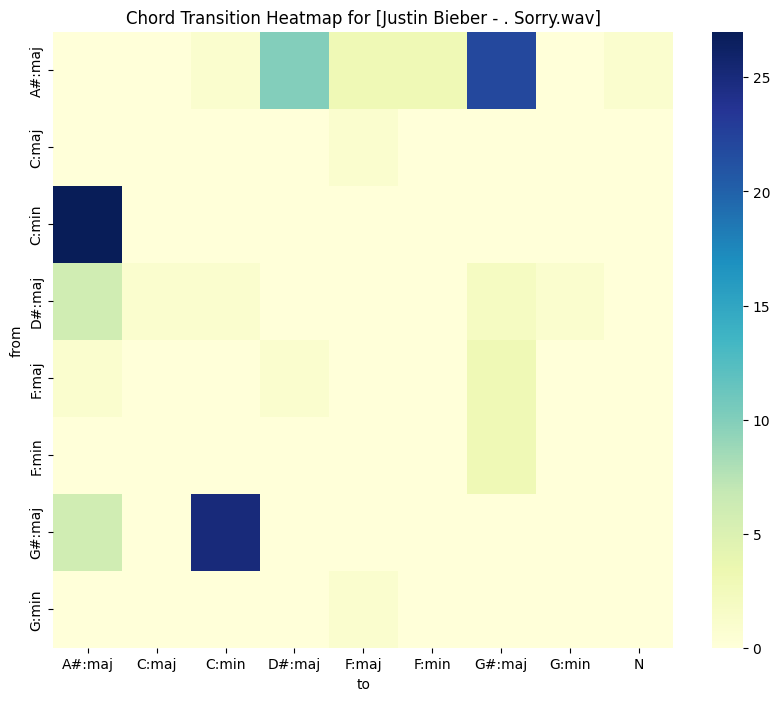

In [71]:
df_song = df[df["filename"] == "Justin Bieber - . Sorry.wav"]
matrix = pd.crosstab(df_song["from"], df_song["to"])

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="YlGnBu", annot=False)
plt.title("Chord Transition Heatmap for [Justin Bieber - . Sorry.wav]")
plt.show()

In [72]:
chords_2 = chordrec("temp_wavs/2/Bruno Mars - That's What I Like.wav") # total 94 unique 45

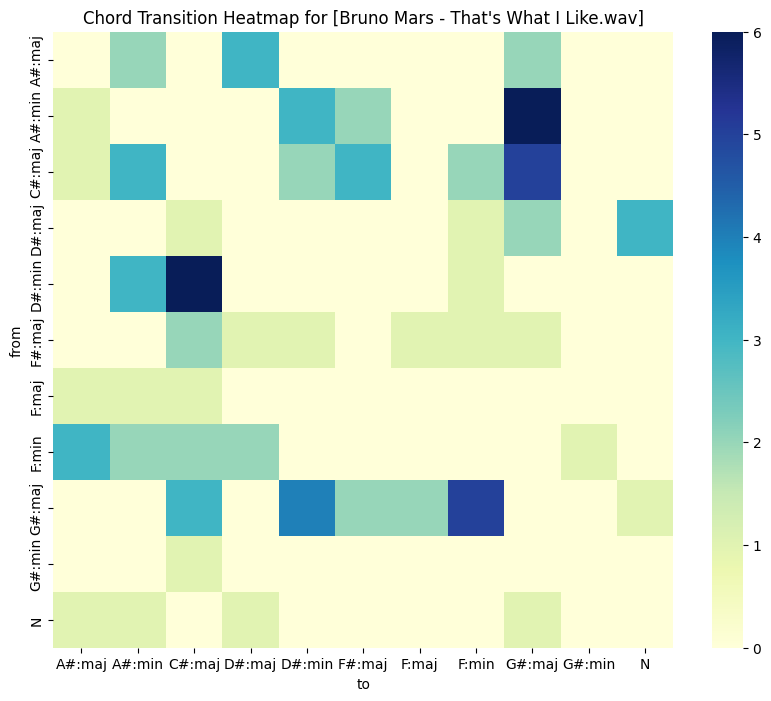

In [73]:
df_song = df[df["filename"] == "Bruno Mars - That's What I Like.wav"]
matrix = pd.crosstab(df_song["from"], df_song["to"])

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="YlGnBu", annot=False)
plt.title("Chord Transition Heatmap for [Bruno Mars - That's What I Like.wav]")
plt.show()

--Match Status

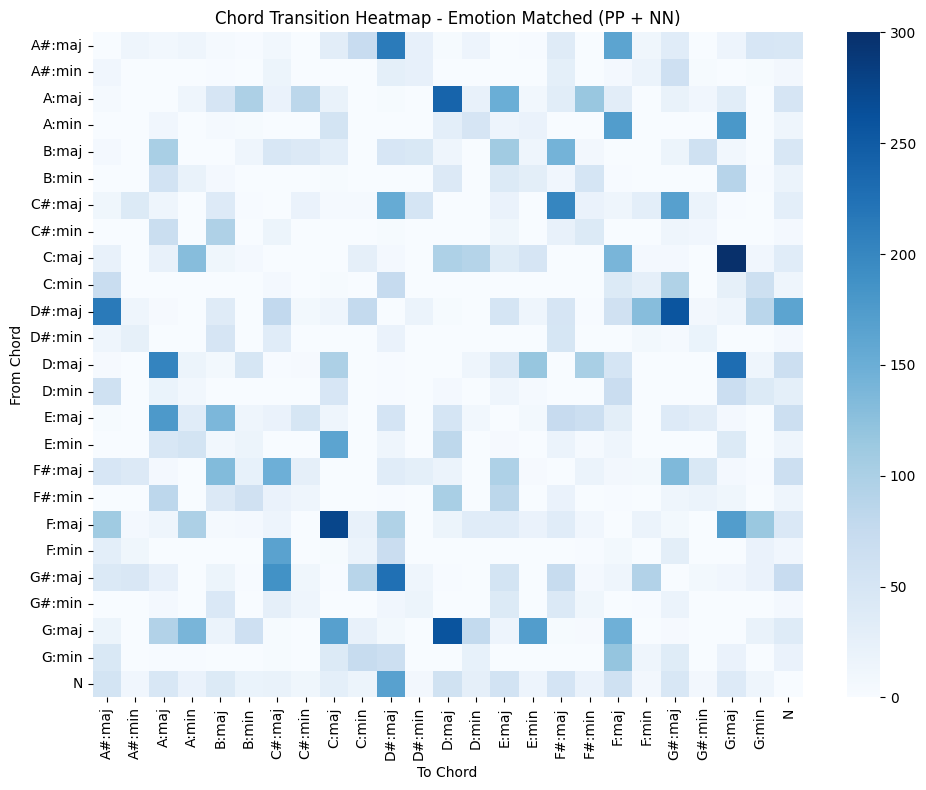

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(match_matrix, annot=False, cmap="Blues")
plt.title("Chord Transition Heatmap - Emotion Matched (PP + NN)")
plt.xlabel("To Chord")
plt.ylabel("From Chord")
plt.tight_layout()
plt.show()

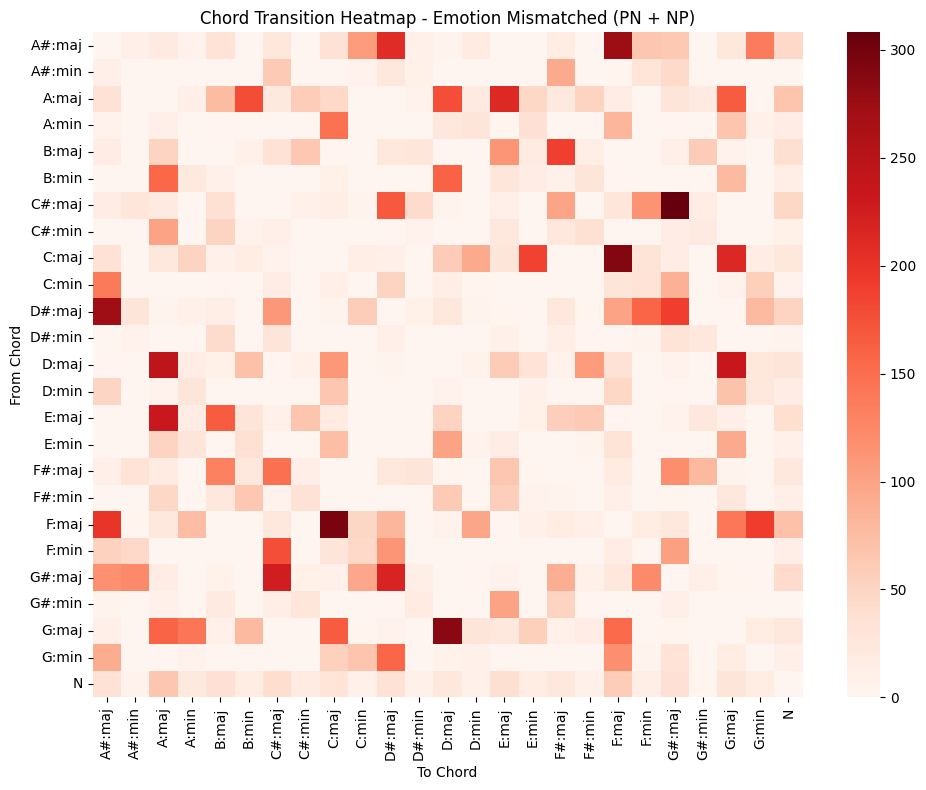

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(mismatch_matrix, annot=False, cmap="Reds")
plt.title("Chord Transition Heatmap - Emotion Mismatched (PN + NP)")
plt.xlabel("To Chord")
plt.ylabel("From Chord")
plt.tight_layout()
plt.show()